<a href="https://colab.research.google.com/github/1boge/my_repos/blob/master/outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание к домашней работе

    
  1) Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет www.kaggle.com...iques/data (train.csv)

  2)  Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
  
  3)  Построить случайный лес, вывести важность признаков
  
  4)  Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
  
  5)  Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
  
  6)  Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
  
  7)  В качестве решения: Jupyter notebook с кодом, комментариями и графиками



In [52]:
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.datasets import load_wine
from sklearn import svm
from sklearn.ensemble import IsolationForest
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [10]:
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(
		model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [19]:
df = pd.read_csv('https://raw.githubusercontent.com/1boge/my_repos/master/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [20]:
X = df.drop(columns='SalePrice')
y = df[['SalePrice']]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [25]:
# находим категориальные признаки

categorials = list(df.dtypes[df.dtypes == object].index)
categorials_nunique = X_train[categorials].nunique()

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
df[categorials] = df[categorials].fillna('nan')

In [26]:
# фильтруем непрерывные признаки
integer = [f for f in df if f not in (categorials + ['ID', 'SalePrice'])]

In [27]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(X_train[categorials], columns=categorials)
dummy_test = pd.get_dummies(X_test[categorials], columns=categorials)
dummy_cols = list(set(dummy_train) & set(dummy_test))
dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]

In [28]:
# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([X_train[integer].fillna(-999), dummy_train], axis=1)
X_test = pd.concat([X_test[integer].fillna(-999), dummy_test], axis=1)

In [31]:
clf_rf = RandomForestRegressor()
clf_rf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor()

In [36]:
print('Score for train data:', clf_rf.score(X_train, y_train))
print('Score for train test:', clf_rf.score(X_test, y_test))

Score for train data: 0.9754255646716732
Score for train test: 0.893984151316511


In [39]:
scores_train = evaluate_model(clf_rf, X_train, y_train)
scores_test = evaluate_model(clf_rf, X_test, y_test)
print('MAE for train:', np.mean(scores_train), np.std(scores_train))
print('MAE for test:', np.mean(scores_test), np.std(scores_test))

MAE for train: -18464.44623615077 2516.928872384124
MAE for test: -19814.330960535586 3816.551805875255


In [40]:
# наиболее важные признаки
imp = pd.Series(clf_rf.feature_importances_)

In [41]:
imp.index = pd.Series(X_train.columns)

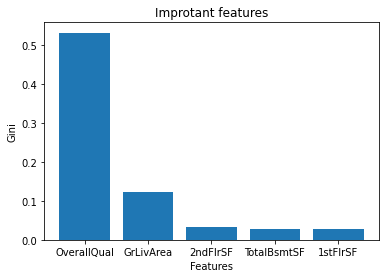

In [42]:
plt.title('Improtant features')
plt.xlabel('Features')
plt.ylabel('Gini')
plt.bar(imp.sort_values(ascending=False).head().index,
        imp.sort_values(ascending=False).head())
plt.show()

In [53]:
# Создаем стекинг и обучаем его
Regressor = StackingRegressor(
    [
        ('LinearRegression', LinearRegression()),
        ('KNeighborsRegressor', KNeighborsRegressor()),
        ('DecisionTree', DecisionTreeRegressor()),
        ('SVM', SVR())
    ], RidgeCV())

In [54]:
Regressor.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_stacking.py:754: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


StackingRegressor(estimators=[('LinearRegression', LinearRegression()),
                              ('KNeighborsRegressor', KNeighborsRegressor()),
                              ('DecisionTree', DecisionTreeRegressor()),
                              ('SVM', SVR())],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [56]:
print(f'Score on train data: {Regressor.score(X_train, y_train)}')
print(f'Score on test data: {Regressor.score(X_test, y_test)}')
for i in Regressor.named_estimators:
    print(f'Score on train data with model "{i}" = {Regressor.named_estimators_[i].score(X_train, y_train)}')
    print(f'Score on test data with model "{i}" = {Regressor.named_estimators_[i].score(X_test, y_test)}')

Score on train data: 0.9388267207949317
Score on test data: 0.8595675016087212
Score on train data with model "LinearRegression" = 0.922108540356243
Score on test data with model "LinearRegression" = 0.8533836050579364
Score on train data with model "KNeighborsRegressor" = 0.7419951520813983
Score on test data with model "KNeighborsRegressor" = 0.6775304068635524
Score on train data with model "DecisionTree" = 1.0
Score on test data with model "DecisionTree" = 0.753093039896126
Score on train data with model "SVM" = -0.04387396175487779
Score on test data with model "SVM" = -0.03198239380278367


**Линейная регрессия показала лучший результат.Деревья решений переобучились.**

In [57]:
score_train = {}
score_test = {}
for i in Regressor.named_estimators:
    score_train[i] = Regressor.named_estimators_[i].score(X_train, y_train)
    score_test[i] = Regressor.named_estimators_[i].score(X_test, y_test)
score_train['Total'] = Regressor.score(X_train, y_train)
score_test['Total'] = Regressor.score(X_test, y_test)

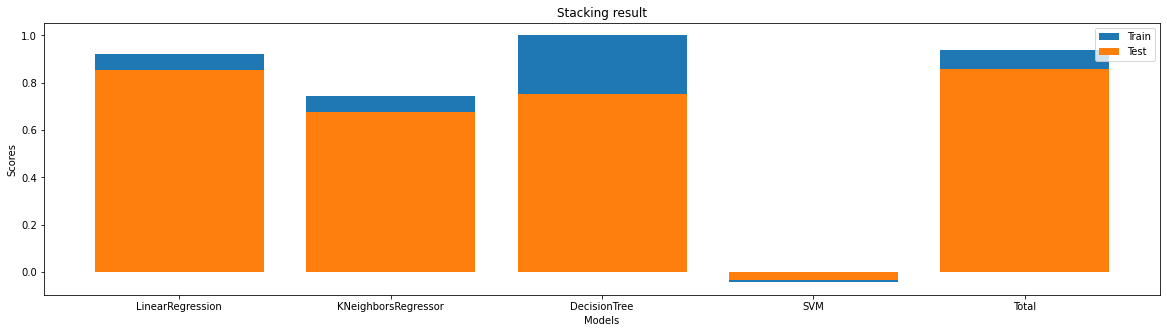

In [63]:
plt.figure(figsize=(20, 5))
plt.bar(range(len(score_train)), score_train.values(),
        align="center", label='Train')
plt.xticks(range(len(score_train)), list(score_train.keys()))
plt.bar(range(len(score_test)), score_test.values(),
        align="center", label='Test')
plt.xticks(range(len(score_test)), list(score_test.keys()))
plt.autoscale
plt.title('Stacking result')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend()